In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/cao-2018/kidney/rna/'
SCATAC_DIR = '../data/cao-2018/kidney/atac/'

# scRNA-seq Data

In [4]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_ids', cache=True)
scrna.obs = pd.read_csv(SCRNA_DIR + 'obs.csv', index_col='sample')
scrna.var = pd.read_csv(SCRNA_DIR + 'var.csv', index_col='gene_id')
scrna

CPU times: user 748 ms, sys: 68 ms, total: 816 ms
Wall time: 943 ms


AnnData object with n_obs × n_vars = 13893 × 49584
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_name'
    var: 'gene_type', 'gene_short_name'

In [5]:
scrna.obs.head()

source    replicate experiment     tsne_1  \
sample                                                                      
coRNA-RNA-plate1-001.TCGGCGTCGT  Mouse  Replicate 1    coassay        NaN   
coRNA-RNA-plate1-001.CATGACTCAA  Mouse  Replicate 1    coassay   2.808426   
coRNA-RNA-plate1-001.CGCCAGGCAT  Mouse  Replicate 1    coassay  -4.660380   
coRNA-RNA-plate1-001.CTGGTTGGTT  Mouse  Replicate 1    coassay        NaN   
coRNA-RNA-plate1-001.CCAGGCTCTT  Mouse  Replicate 2    coassay  10.309332   

                                    tsne_2                    cell_name  
sample                                                                   
coRNA-RNA-plate1-001.TCGGCGTCGT        NaN                          NaN  
coRNA-RNA-plate1-001.CATGACTCAA -45.948924         Loop of Henle cells   
coRNA-RNA-plate1-001.CGCCAGGCAT -41.004499         Loop of Henle cells   
coRNA-RNA-plate1-001.CTGGTTGGTT        NaN                          NaN  
coRNA-RNA-plate1-001.CCAGGCTCTT  11.143745  Proximal tubule S1/S2 cells

In [6]:
scrna.var.head()

gene_type gene_short_name
gene_id                                                   
ENSMUSG00000102693.1                   TEC   4933401J01Rik
ENSMUSG00000064842.1                 snRNA         Gm26206
ENSMUSG00000051951.5        protein_coding            Xkr4
ENSMUSG00000102851.1  processed_pseudogene         Gm18956
ENSMUSG00000103377.1                   TEC         Gm37180

## Data Cleaning

In [7]:
scrna = scrna[~scrna.obs['cell_name'].isna()]

In [8]:
scrna.obs = scrna.obs.rename(columns={'cell_name': 'cell_type'})

In [9]:
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [10]:
scrna.obsm['X_tsne'] = scrna.obs[['tsne_1', 'tsne_2']].to_numpy()

In [11]:
scrna

AnnData object with n_obs × n_vars = 10727 × 49584
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type'
    var: 'gene_type', 'gene_short_name'
    obsm: 'X_tsne'

# Quality Control

In [12]:
scrna.var_names_make_unique()

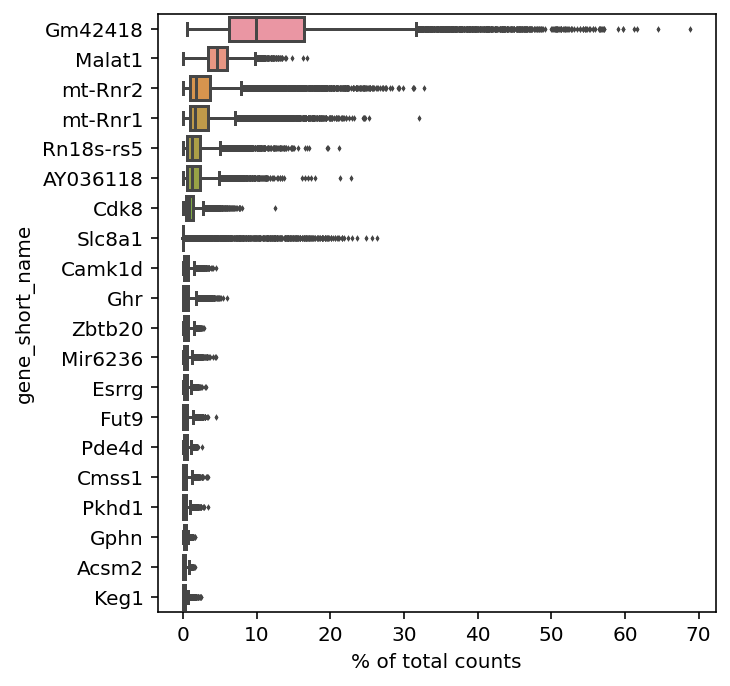

In [13]:
sc.pl.highest_expr_genes(scrna, n_top=20, gene_symbols='gene_short_name')

In [14]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 10548 × 23362
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes'
    var: 'gene_type', 'gene_short_name', 'n_cells'
    obsm: 'X_tsne'

## Qalculate QC metrics including Mitochondrial genes

In [15]:
scrna.var['mt'] = scrna.var['gene_short_name'].str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 10548 × 23362
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_tsne'

... storing 'source' as categorical
... storing 'replicate' as categorical
... storing 'experiment' as categorical
... storing 'gene_type' as categorical
... storing 'gene_short_name' as categorical


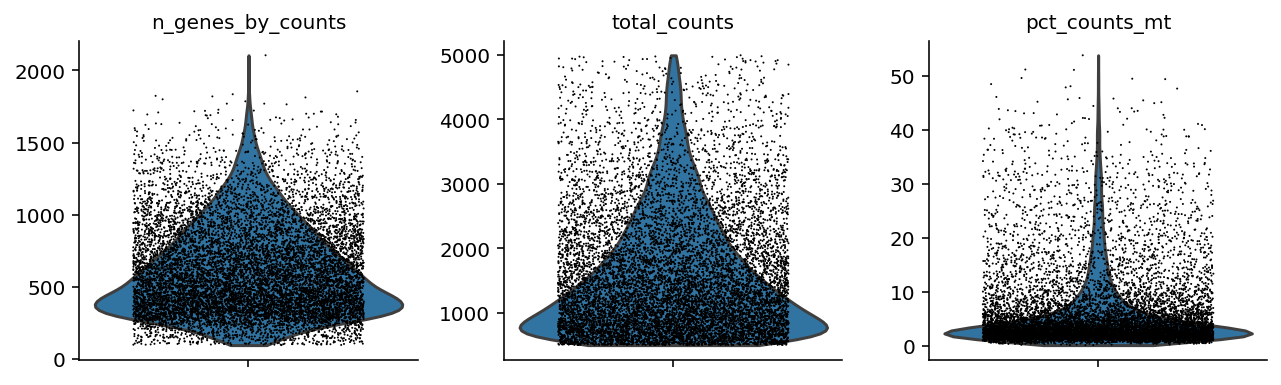

In [16]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

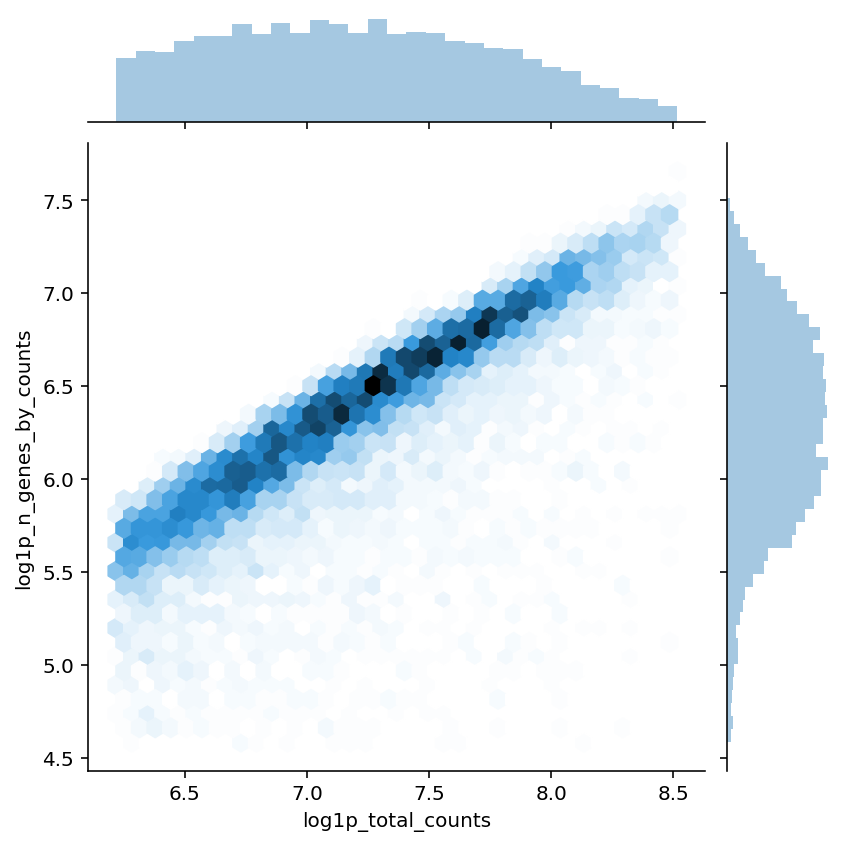

In [17]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex');

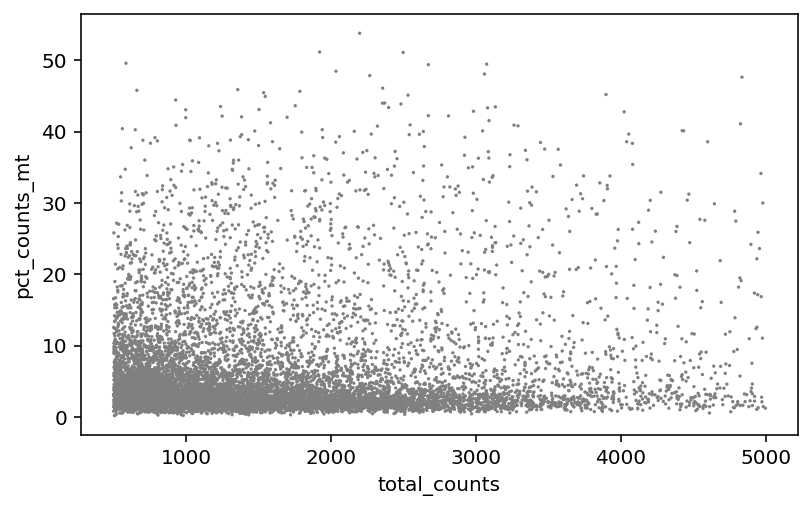

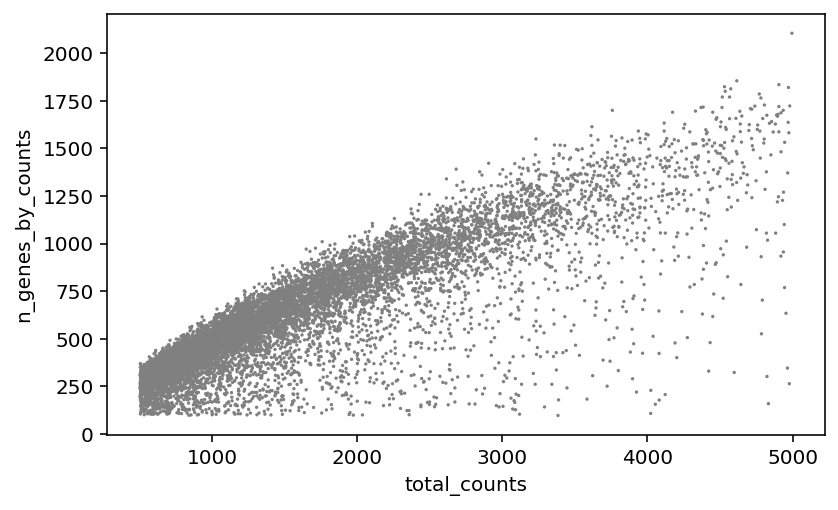

In [18]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out high mitochondrial samples and samples with highest number of genes:

In [19]:
scrna = scrna[scrna.obs.n_genes_by_counts < 1500, :]
scrna = scrna[scrna.obs.pct_counts_mt < 15, :]
scrna

View of AnnData object with n_obs × n_vars = 9328 × 23362
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_tsne'

## Normalization

In [20]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

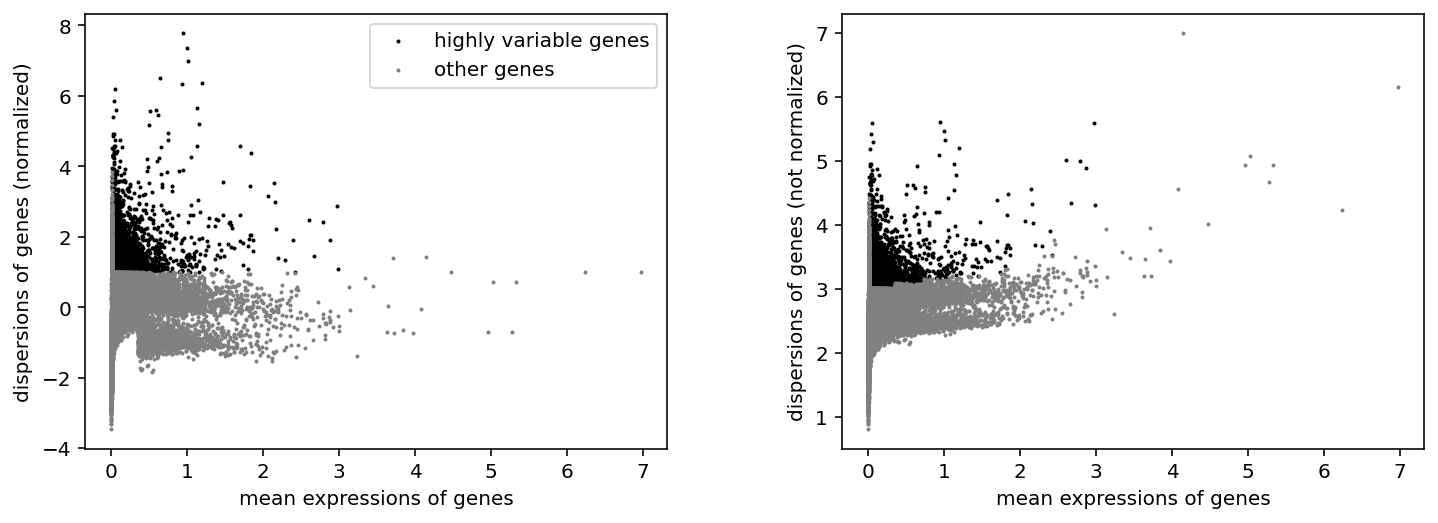

In [21]:
sc.pp.highly_variable_genes(scrna, min_mean=0.0125, max_mean=3, min_disp=1)
sc.pl.highly_variable_genes(scrna)

In [22]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 9328 × 2861
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 'X_tsne'

## Visualization

### t-SNE using coordinates provided by the authors

Trying to set attribute `.uns` of view, copying.


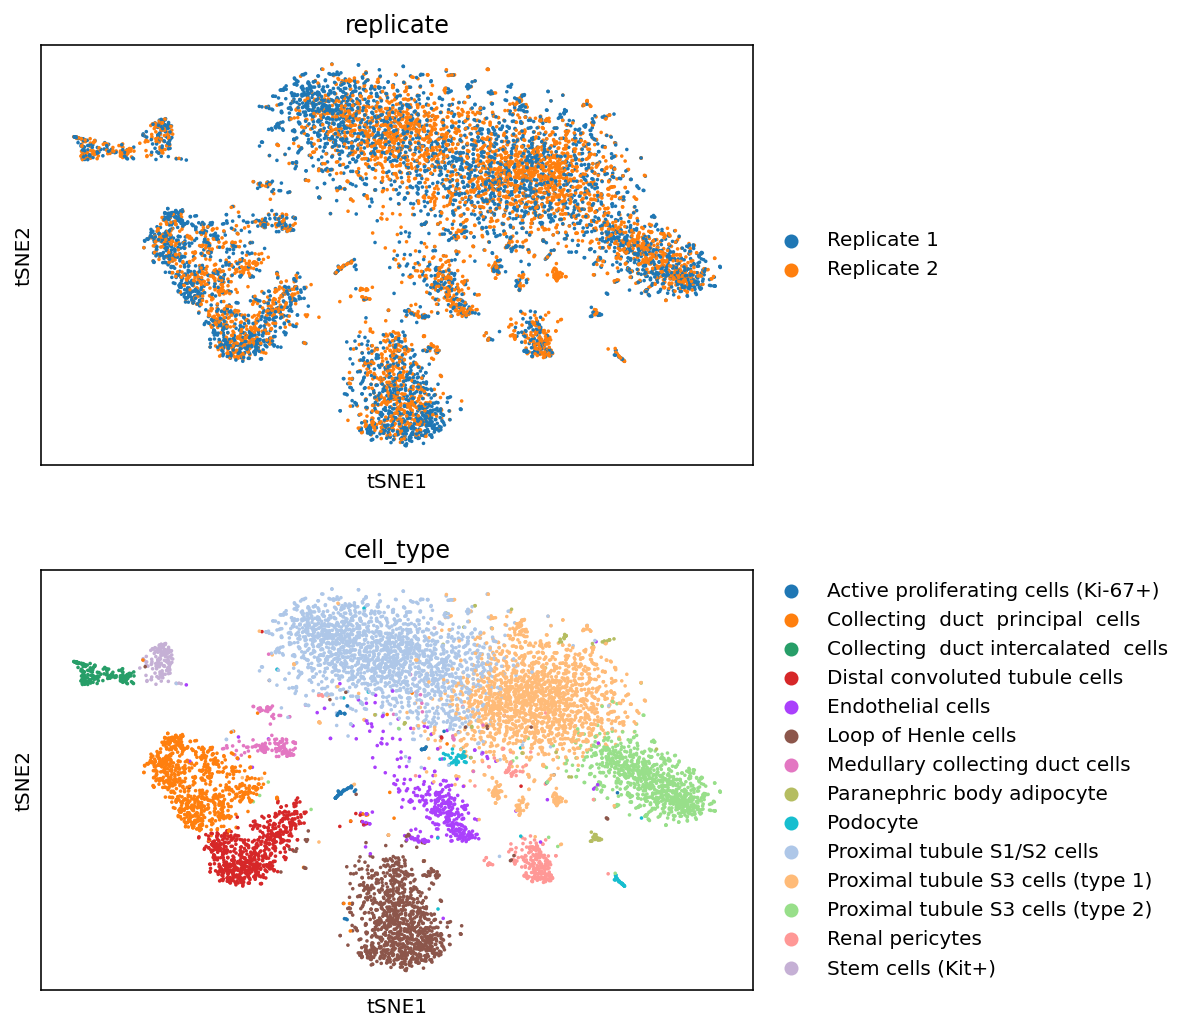

In [23]:
sc.pl.tsne(scrna, color=['replicate', 'cell_type'], ncols=1)

### Running UMAP

In [24]:
sc.pp.neighbors(scrna, random_state=42)
sc.tl.umap(scrna, random_state=42)

         Falling back to preprocessing with `sc.pp.pca` and default params.


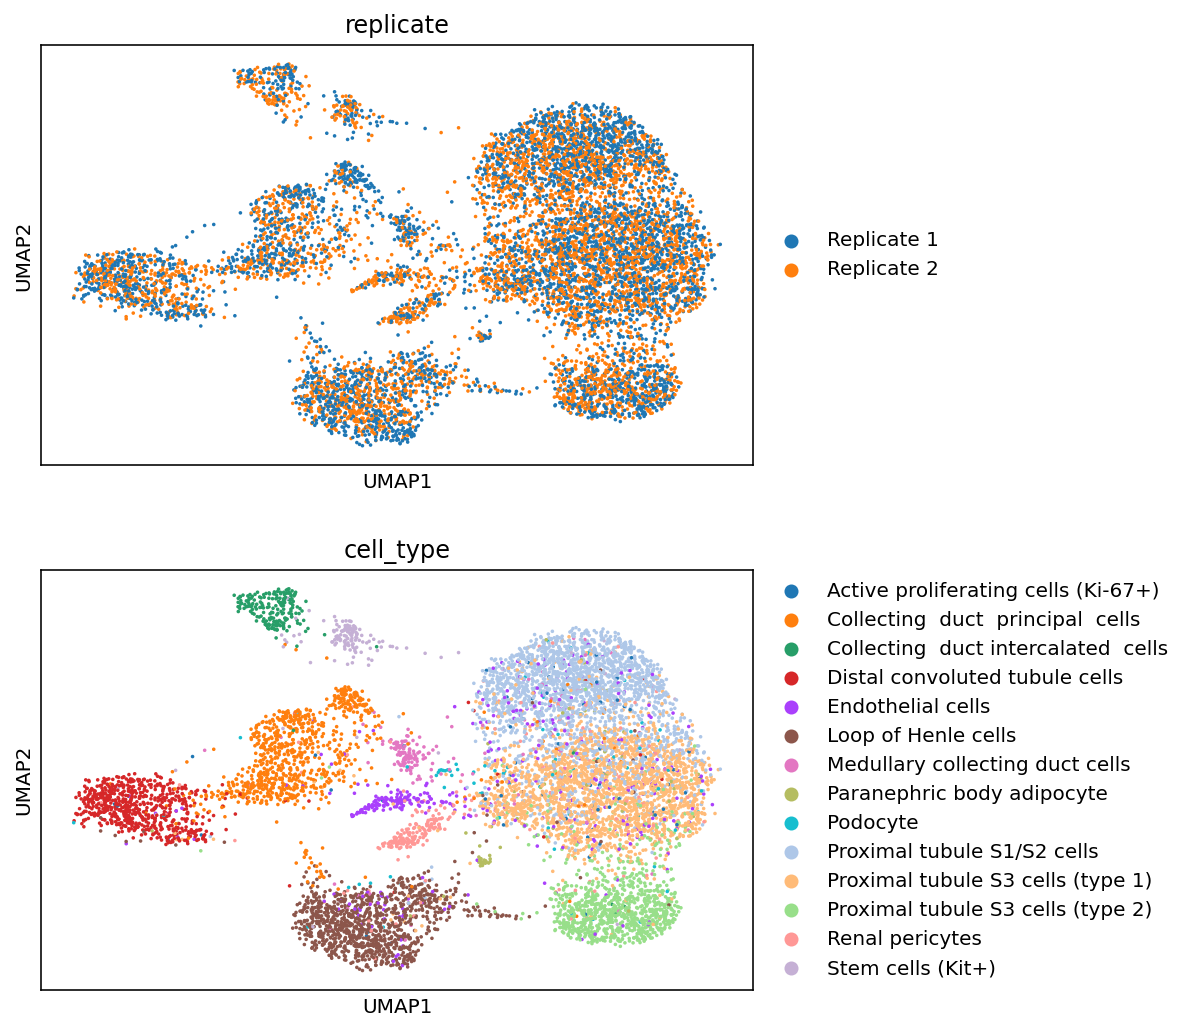

In [25]:
sc.pl.umap(scrna, color=['replicate', 'cell_type'], ncols=1)

---
# scATAC-seq Data

In [26]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, cache=True)
# scatac.obs = pd.read_csv(SCATAC_DIR + 'obs.csv', index_col='sample')
# scatac.var = pd.read_csv(SCATAC_DIR + 'var.csv', index_col='gene_id')
scatac

CPU times: user 1.44 s, sys: 628 ms, total: 2.07 s
Wall time: 2.32 s


AnnData object with n_obs × n_vars = 13395 × 252741
    var: 'gene_ids'

In [ ]:
scatac.obs

In [29]:
scatac.var.head()

gene_ids
1                                                   
chr10:10000000-10001000      chr10:10000000-10001000
chr10:100000000-100001000  chr10:100000000-100001000
chr10:100002000-100003000  chr10:100002000-100003000
chr10:100003000-100004000  chr10:100003000-100004000
chr10:100004000-100005000  chr10:100004000-100005000

## Data Cleaning

In [30]:
scatac.obs = scatac.obs.rename(columns={'Cluster': 'cell_type'})

In [31]:
scatac.obs['cell_type'] = scatac.obs['cell_type'].apply(lambda x: cell_types_map[x])

In [32]:
scatac.obs['Rep'] = scatac.obs['Rep'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

In [33]:
scatac.obsm['X_umap'] = scatac.obs[['DNA_Dim1', 'DNA_Dim2']].to_numpy()

In [34]:
scatac

AnnData object with n_obs × n_vars = 15191 × 2614863 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

## Binarization

In [35]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

CPU times: user 3.91 s, sys: 4.01 s, total: 7.92 s
Wall time: 9.07 s


AnnData object with n_obs × n_vars = 15191 × 2614863 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

## Quality Control

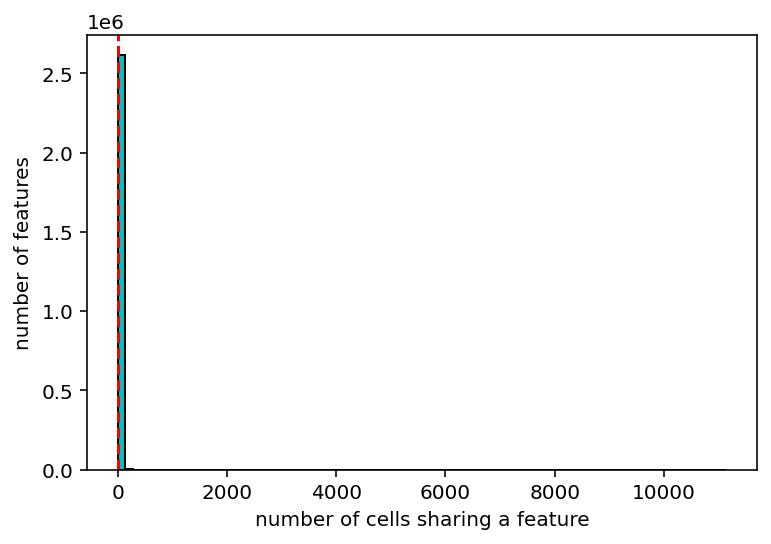

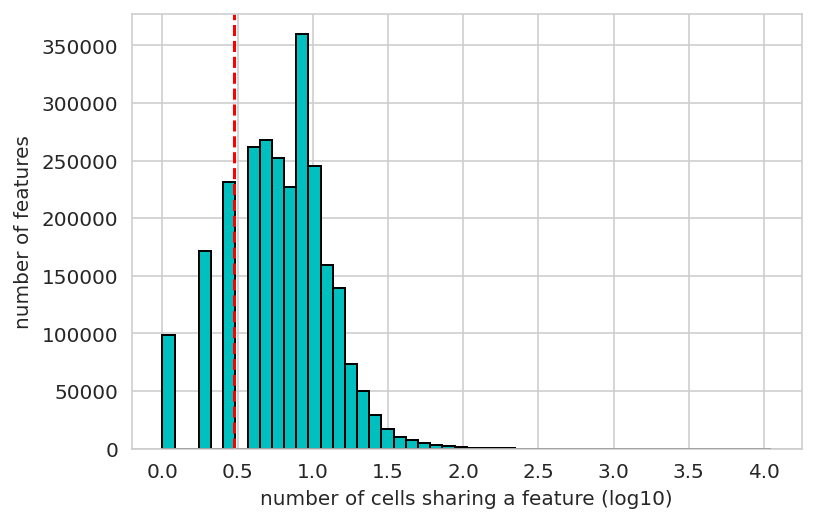

In [36]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=3)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=3)

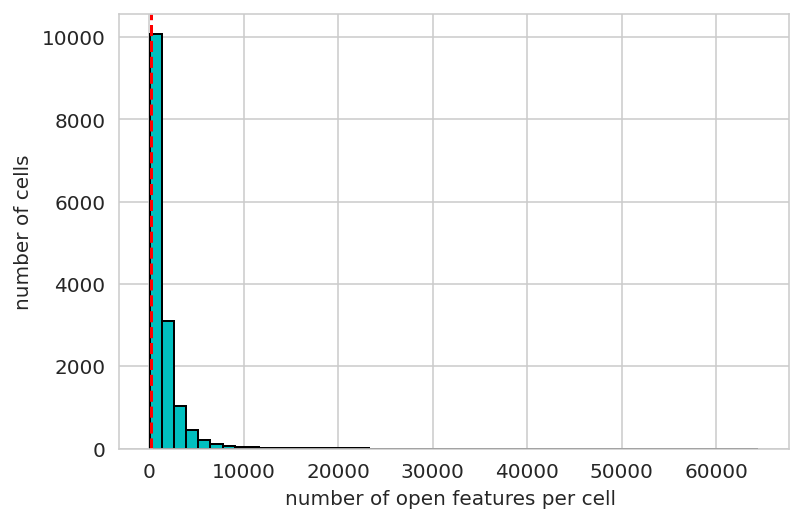

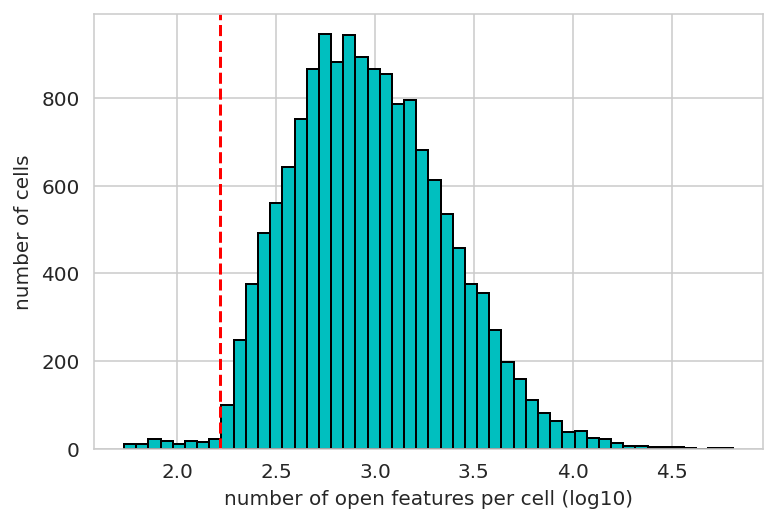

In [37]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=165)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=165)

## Filter low quality cells and peaks

In [38]:
epi.pp.filter_cells(scatac, min_features=165)
epi.pp.filter_features(scatac, min_cells=3)
scatac

AnnData object with n_obs × n_vars = 15071 × 2344311 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells'
    obsm: 'X_umap'

In [39]:
scatac.obs['nb_features'].describe()

count    15071.000000
mean      1486.262955
std       2041.771778
min        167.000000
25%        499.500000
50%        894.000000
75%       1725.000000
max      64438.000000
Name: nb_features, dtype: float64

In [40]:
scatac.var['commonness'].describe()

count    2.344311e+06
mean     9.371117e+00
std      3.649082e+01
min      3.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      1.114100e+04
Name: commonness, dtype: float64

In [41]:
scatac.var['commonness'].median()

7.0

In [42]:
scatac = scatac[:, scatac.var['commonness'] > 7]
scatac

View of AnnData object with n_obs × n_vars = 15071 × 1104393 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells'
    obsm: 'X_umap'

## Selecting variable peaks

Trying to set attribute `.var` of view, making a copy.


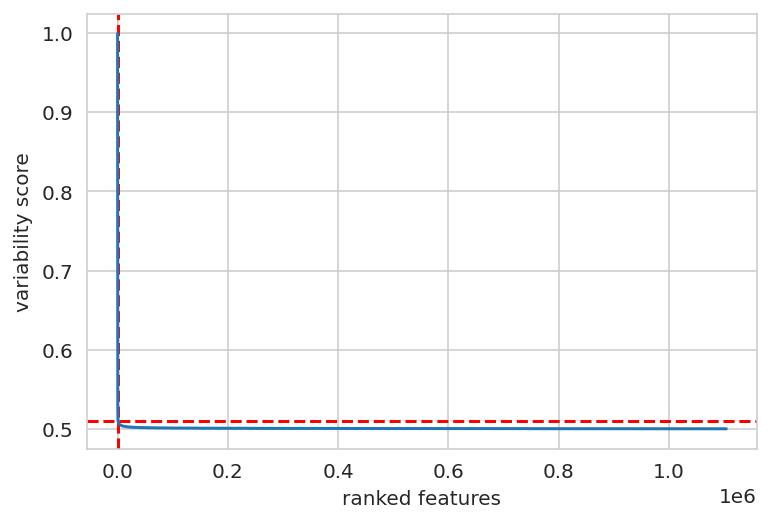

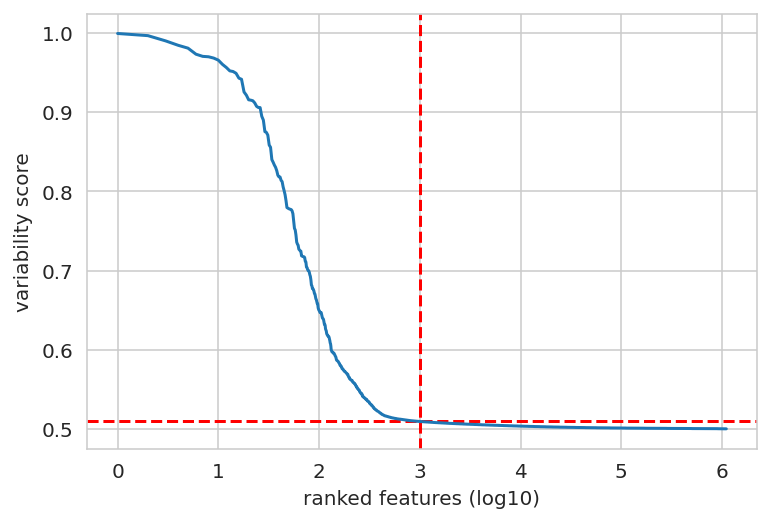

In [43]:
min_score_value = 0.51
nb_feature_selected = 1000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

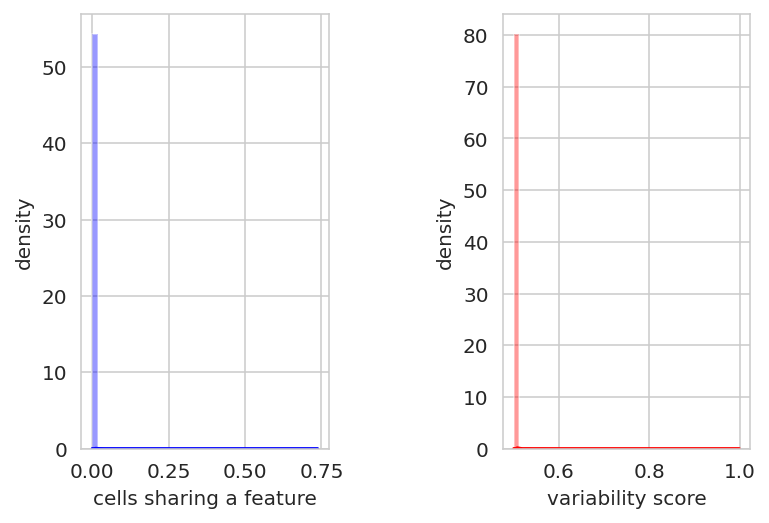

CPU times: user 3.77 s, sys: 1.16 s, total: 4.94 s
Wall time: 5.05 s


In [44]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

In [45]:
scatac

View of AnnData object with n_obs × n_vars = 15071 × 1002 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

## Visualization

### UMAP using coordinates provided by the authors

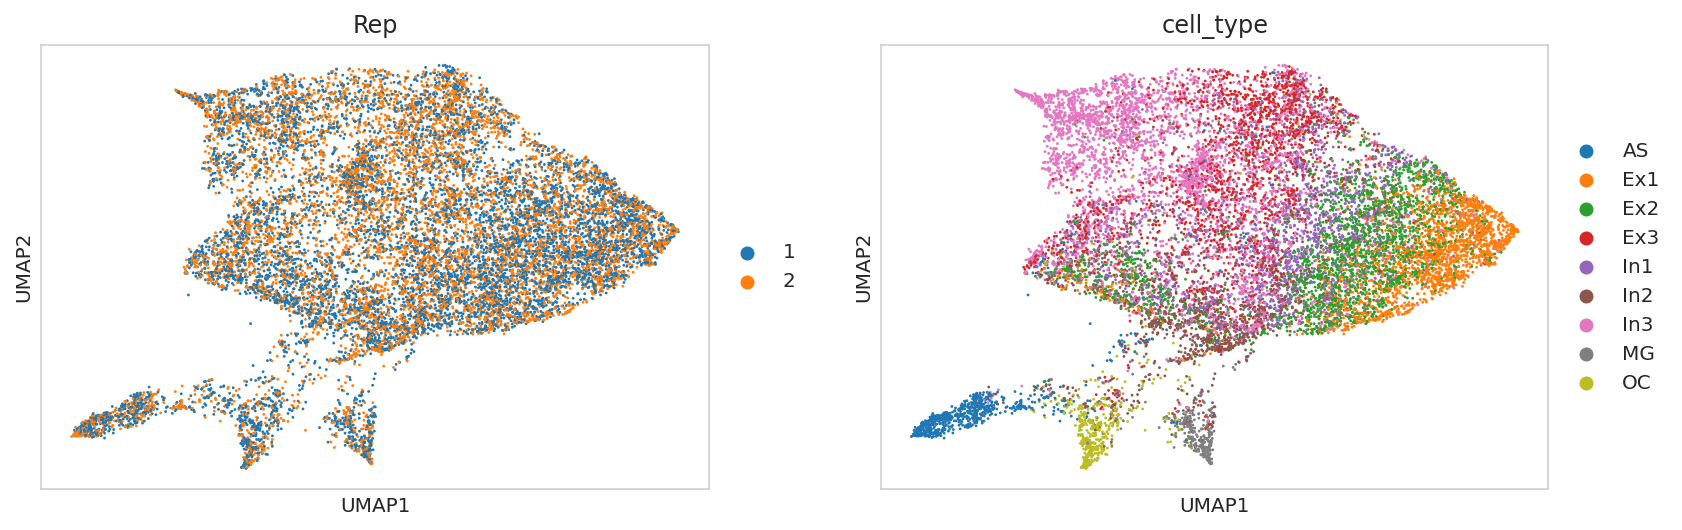

In [47]:
sc.pl.umap(scatac, color=['Rep', 'cell_type'])

### Running UMAP

In [48]:
sc.pp.neighbors(scatac, random_state=42)
sc.tl.umap(scatac, random_state=42)

         Falling back to preprocessing with `sc.pp.pca` and default params.


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



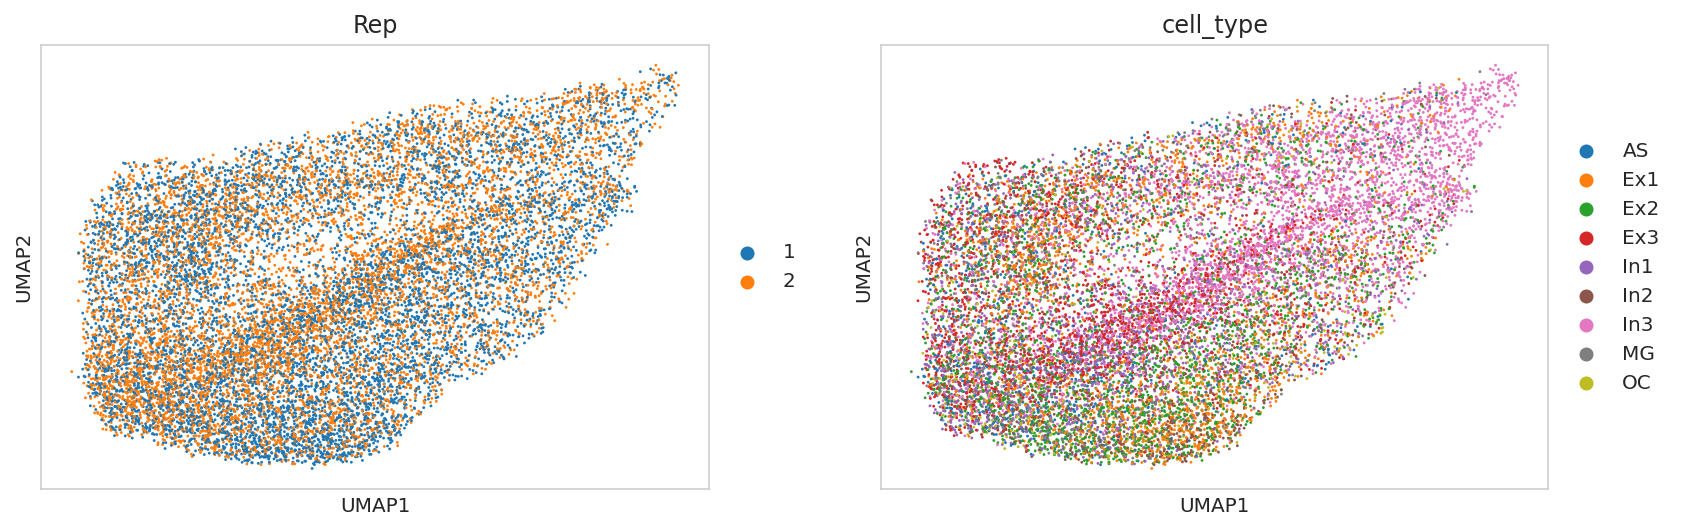

In [49]:
sc.pl.umap(scatac, color=['Rep', 'cell_type'])

---
# Save the results

### Find common paired samples

In [50]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(14883, 2693) (14883, 1002)


In [51]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 168 ms, sys: 36 ms, total: 204 ms
Wall time: 302 ms


In [52]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 160 ms, sys: 56 ms, total: 216 ms
Wall time: 287 ms
